## EDA of Weekly Sales Data
By: Akash Wudali

### Overview:
This project explores the factors that affect weekly sales in various departments across 45 locations of a major U.S. department store. Key variables such as temperature, fuel prices, and price markdowns are analyzed to understand their impact on sales. By examining these relationships, I aim to provide insights into how the store can improve sales across its 45 locations.

In addition to this analysis, I built a regression model to predict the sales of Department 28 based on the temperature during a given week. I also used a Recurrent Neural Network (RNN) to model the total sales over 50 weeks for the first location in the store chain (Store 1).

This notebook walks through the steps taken to clean, process, analyze, and model the data, providing actionable insights for both department store owners and potential investors. 

This jupyter notebook and the graphs generated by the notebook can be found in this GitHub

### Importing Libraries

Below, I am importing the necessary libraries for this project. I used pandas to read data from the CSV files and to remove any data points with a large number of missing features or sales data. I used matplotlib to create all the plots, numpy to generate datasets for the machine learning models, and datetime to convert the dates into a numerical format.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

### Combining the Features and Weekly Sales Data into One DataFrame

In the cell below, I combine the weekly sales data and features data into a single DataFrame and save it into a file. This will be useful later for determining relationships between features and weekly sales. Additionally, aggregating all the data into one file simplifies the data cleaning process. I saved the combined DataFrame to the `parsed_store_data.csv` file.

In [25]:
dept_price_df  = pd.read_csv("data/train.csv")
df = pd.read_csv("data/features.csv")

for index, row in dept_price_df.iterrows():
    matching_row = df.index[(df["Date"] == row["Date"]) & (df["Store"] == row["Store"])]
    df.loc[matching_row, "Dept " + str(row["Dept"])] = row["Weekly_Sales"]
    
df.to_csv("data/parsed_store_data.csv")

Reading the new generated csv file into the pandas dataframe pdf

In [2]:
pdf = pd.read_csv("data/parsed_store_data.csv") # reading the new csv

### Initial Observations:

Before performing any numerical analysis on the data, I reviewed the raw CSV file to identify any obvious patterns that could guide the data cleaning process and simplify data analysis. Here are some of my observations:

1. Whenever the first markdown data was missing, all subsequent markdowns were also missing. Similarly, when the sales data for the first department was missing, the sales data for all departments was missing. This meant that I only needed to check if the first markdown and department were missing data to decide if the entire row should be removed, greatly simplifying the data cleaning process.
   
2. A few departments had a majority of their sales data missing. I made sure to remove these departments during the data cleaning process, as they could potentially skew the results for the other departments.
   
3. Some departments had mostly complete sales data but still had instances of missing values. For these departments, I set the missing values to zero since there weren’t enough missing values to significantly skew the data.
   
4. I noticed that sales in Department 92 varied significantly across locations. At some locations, weekly sales exceeded $160,000, while at other locations, they were around $9,000.


### getDateInt Helper Method

In the `getDateInt` helper method below, I convert the dates into numeric values. The method uses November 11, 2011, as the start date because, after cleaning the data, this was the earliest date with usable data.

In [4]:
def getDateInt(dateStr):
    year, month, day = dateStr.split("-")
    year, month, day = int(year), int(month), int(day)

    startdate = datetime(2011, 11, 11)
    enddate = datetime(year, month, day)

    return (enddate - startdate).days / 7

In [5]:
print(getDateInt("2011-11-11"))
print(getDateInt("2011-12-02"))

0.0
3.0


### Data Cleaning and Preprocessing

The cell below performs the following data processing operations:
1. Removed all rows where the first markdown or the first department's sales statistics were missing. As mentioned in my previous observations, this indicated that the row was missing data for all markdowns or departments.
2. Removed all columns where at least 70% of the department sales data was missing.
3. Converted the `Date` column from a date string format to a numeric value, where 0 represents the first week.

I saved this cleaned DataFrame to the `clean_data.csv` file.

In [118]:
pdf = pdf[np.isnan(pdf["MarkDown1"]) == False] # first markdown nan, every other markdown nan, drop the data
pdf = pdf[np.isnan(pdf["Dept 1"]) == False] # first Dept being nan indicates there is no price data

# start date 2011-11-11
# end date 2012-10-26
date_ct = 0
curr_store = 1

for col in pdf.columns:
    nan_ct = 0
    if "Dept" in col:
        for index, row in pdf.iterrows():
            if np.isnan(row[col]):
                nan_ct += 1
        if nan_ct / pdf.shape[0] >= 0.7:
            pdf = pdf.drop(col, axis=1)

pdf["Date"] = pdf["Date"].apply(getDateInt)

pdf.to_csv("data/clean_data.csv")

In [4]:
pdf = pd.read_csv("data/clean_data.csv")

In [5]:
departments = [col for col in pdf.columns if "Dept" in col]

### Extracting Relevant Data

In the cell below, I extracted the data from the cleaned pandas DataFrame. To store this data, I utilized three Python dictionaries: `x_time`, `x_features`, and `y_sales`. The key for all three dictionaries is the store number, and the values are as follows:
- `x_time`: The current timestep (date represented as a number).
- `x_features`: The features (such as temperature and fuel price) at a particular timestep.
- `y_sales`: The sales numbers for each department at that timestep.

The reasoning behind this approach is to enable quick and easy access to the features and sales data for any specific store at any given date, without having to repeatedly search through the DataFrame.


In [9]:
#graph relevant data

x_time = {}
x_features = {}
y_sales = {}

for index, row in pdf.iterrows():
    if not row["Store"] in x_time:
        x_time[int(row["Store"])] = [row["Date"]]
        x_features[int(row["Store"])] = [[row["Temperature"], row["Fuel_Price"], row["CPI"], row["Unemployment"], int(row["IsHoliday"]=="FALSE")] 
                                    + [row["MarkDown" + s] if not np.isnan(row["MarkDown" + s]) else 0 for s in "12345"]]
        y_sales[int(row["Store"])] = [[row[dept] if not np.isnan(row[dept]) else 0 for dept in departments]]
    else:
        x_time[int(row["Store"])].append(row["Date"])
        x_features[int(row["Store"])].append([row["Temperature"], row["Fuel_Price"], row["CPI"], row["Unemployment"], int(row["IsHoliday"]=="FALSE")] 
                                    + [row["MarkDown" + s] if not np.isnan(row["MarkDown" + s]) else 0 for s in "12345"])
        y_sales[int(row["Store"])].append([row[dept] if not np.isnan(row[dept]) else 0 for dept in departments])

### Organizing Sales Data for Each Store

The code below organizes the sales data for each department in every store over time. For each of the 45 stores, it creates a dictionary `store_department_sales` that maps the store number to the sales data of its departments over time. This allows for easy access to the sales data of each individual department, making it convenient for tasks such as creating heatmaps to plot the covariance between the features (e.g., temperature, fuel prices) and the sales figures for each department in each store.

In [123]:
# making plots for each store

store_department_sales = {}

for i in range(45): # 45 stores
    store_times = x_time[i + 1]
    store_features = x_features[i + 1]
    store_sales = y_sales[i + 1]
    
    y_mat = [[] for d in departments] # will map the sales for each store for each department

    for time in range(len(store_times)):
        current_department_sales = store_sales[time]
        for d in range(len(departments)):
            y_mat[d].append(current_department_sales[d])
            
    store_department_sales[i + 1] = y_mat

### Analyzing the Effects of Features on Department Sales Using Covariance

To determine the extent to which each feature (temperature, fuel price, etc.) affects each department's sales, I created a heatmap showing the covariance between every feature and each department's sales figures. Below is an example for the first store:

![Heatmap of covariance between features and department sales of store 1](figures/Covariance-of-various-factors-on-Store-1's-sales.png)

### Overview of Covariance

Covariance is a statistical measure that quantifies the degree of linear relationship between two variables. A covariance of 1 indicates a perfect positive correlation (as one variable increases, the other increases as well), while a covariance of -1 indicates a perfect negative correlation (as one variable increases, the other decreases). A higher absolute value of covariance indicates a stronger relationship between the two variables. In this context, covariance helps determine which features of a store location impact its performance.

### Observations Based on the Plots

The covariance between the sales of each store's departments and various features showed slight variations across stores, allowing for specific insights and actions to be tailored to improve each location. Using the first store as an example (as shown in the heatmap above), the following insights can be drawn:

1. The unemployment rate has a strong positive correlation with the sales of department 5, indicated by the yellow square above department 5. Additionally, the Consumer Price Index (CPI) has a strong negative correlation with department 5's sales, as shown by the dark purple square.
2. Department 28 has a high negative correlation with temperature, suggesting that department 28 tends to perform better during winter months, as sales increase when temperatures decrease.
3. Unemployment has a strong positive correlation with department 55’s performance, while CPI shows a strong negative correlation. Since CPI and unemployment are highly related, we can use these two factors to predict trends in department 55's sales.

Similar observations can be made for every department across all store locations, providing valuable insights for business strategies and investment decisions.

The code for generating these plots are in the next 4 code cells. I generated similar plots for every store and department, which can be found in this [GitHub link].

In [129]:
def cov(X, Y):
    x_mean = mean(X)
    y_mean = mean(Y)
    c = sum([(X[i] - x_mean) * (Y[i] - y_mean) for i in range(len(X))]) / len(X)
    return c / (stdev(X)*stdev(Y))

def mean(X):
    return np.mean(X)

def stdev(X):
    return np.std(X)


In [125]:
print(cov([1, 2, 3], [1, 2, 3]))

1.0


In [126]:
# calculating the covariance between each of the features and the department prices
# shows what factors about the stores are important in terms of sales, and how different factors effect different departments within a store

from pprint import pprint

features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "IsHoliday"] + ["MarkDown" + s for s in "12345"]
cov_lst = []
stores_to_cov = {}

for store in x_features:
    store_features = x_features[store]
    department_sales = store_department_sales[store]
    for d in range(len(departments)):
        current_dept_sales = department_sales[d]
        temperature = []
        fuel_price = []
        cpi = []
        unemp = []
        avg_mkd = []
        for time_step in range(len(current_dept_sales)):
            temperature.append(store_features[time_step][0])
            fuel_price.append(store_features[time_step][1])
            cpi.append(store_features[time_step][2])
            unemp.append(store_features[time_step][3])
            avg_mkd.append(mean([m for m in store_features[time_step][5:]]))
        temp_cov_sales = cov(temperature, current_dept_sales)
        fp_cov = cov(fuel_price, current_dept_sales)
        cpi_cov = cov(cpi, current_dept_sales)
        unemp_cov = cov(unemp, current_dept_sales)
        avg_mkd_cov = cov(avg_mkd, current_dept_sales)
        cov_lst = [temp_cov_sales, fp_cov, cpi_cov, unemp_cov, avg_mkd_cov]
        stores_to_cov[f"Store {store} {departments[d]}"] = cov_lst

# pprint(stores_to_cov)

/var/folders/k7/p7bz_rpj0xq6gwg34bww6frm0000gn/T/ipykernel_31956/940107010.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return c / (stdev(X)*stdev(Y))


In [128]:
# graphing covarience using heapmap
feature_labels = ["Temperature", "Fuel Price", "CPI", "Unemployment", "Average Markdown"]

for store in range(45):
    plt.figure() 
    fig, ax = plt.subplots(figsize=(25, 4))

    ax.set_xticks(np.arange(len(departments)), labels=departments)
    ax.set_yticks(np.arange(len(feature_labels)), labels=feature_labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    arr = [[0 for i in range(69)] for j in range(5)]
    
    for d in range(len(departments)):
        covars = stores_to_cov[f"Store {store + 1} {departments[d]}"]
        for f in range(len(covars)):
            arr[f][d] = covars[f]
    
    im = ax.imshow(np.array(arr))
        
    ax.set_title(f"Covariance of various factors on Store {store + 1}'s sales")
    ax.set_xlabel(f"Departments in store {store + 1}")
    ax.set_ylabel(f"Factors effecting store price")

    plt.colorbar(im)
    plt.savefig(f"figures/Covariance-of-various-factors-on-Store-{store + 1}'s-sales.png")
plt.show()


### Using Covariance to Aid in Sales Forecasting

One application of covariance is identifying relationships that can be modeled using linear or polynomial regression. One key observation I made was that Department 28 had a strong negative covariance with temperature across many stores. To further illustrate this relationship, I created a bar plot showing the covariance between Department 28's sales and temperature across all stores. The graph is shown below:

![Covariance-Between-Sales-and-Temperature-in-Department-28](figures/Covariance-Between-Sales-and-Temperature-in-Department-28.png)

As seen in the graph, several stores have covariances at or below -0.8, indicating a very strong negative correlation between Department 28's sales and temperature. To determine which stores would yield the most accurate predictions using a Linear Regression model, I identified all stores where the covariance between Department 28's sales and temperature was at or below -0.8. The result was that Stores 1, 2, 6, 10, 12, 13, 17, 21, 28, and 31 matched this criterion.

Since a high covariance indicates a strong linear relationship, I implemented a Linear Regression model to predict Department 28's sales for the 10 stores listed above. Below is a graph displaying the predicted and actual values from the model, capturing the general sales trends of Department 28 based on temperature:

![Department-28-Regression-Analysis](figures/Department-28-Regression-Analysis.png)

### Insights from the Regression Model

The regression model showed that in stores with a strong negative covariance between sales and temperature, the model was able to capture the overall downward trend in sales as temperatures increased. For these stores, the model predicted that during colder months, Department 28 would generally see higher sales, whereas warmer temperatures would lead to a noticeable decline in sales. This insight is useful for store managers to adjust inventory and marketing strategies for Department 28 in line with seasonal temperature changes.

By determining the covariance before applying the linear model, we were able to identify stores with a strong linear relationship between temperature and sales, allowing us to focus our efforts on stores where a linear regression would be most effective. This saves significant computational resources since linear models are far more efficient to compute compared to more complex models like polynomial regression or machine learning algorithms. This approach ensures we are only applying computationally expensive models to stores that truly require them.

In addition, while the linear regression model worked well for stores with strong negative covariance, it might not perform as well in stores with weaker or more complex relationships between temperature and sales. In those cases, more advanced models, such as polynomial regressions or machine learning algorithms, may be necessary to capture the nuances of these relationships.

The code for creating these graphs and the linear regression model can be found in the next 2 code cells below.

In [136]:
# department 28 has a very high covariance with temperature across a majority of the stores

ax, fig = plt.subplots()
best_stores = []
for store in range(45):
    department_covars = stores_to_cov[f"Store {store + 1} Dept 28"]
    temp_covar = department_covars[0]
    if temp_covar <= -0.8:
        best_stores.append(store + 1)
    plt.bar(store + 1, temp_covar, align='center', color="g")
fig.set_title("Covariance Between Sales and Temperature in Department 28")
fig.set_xlabel("Store Number")
fig.set_ylabel("Covariance between sales and temperaure")
plt.savefig("figures/Covariance-Between-Sales-and-Temperature-in-Department-28.png")

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# regression analysis, with stores that have a high covariance with temperature
# remove holiday's as obvious outliers
# clearly able to predict trends
print(best_stores)

temps, dept_28_sales = [], []
for index, row in pdf.iterrows():
    if row["Store"] in best_stores and not row["IsHoliday"]:
        curr_temp = row["Temperature"]
        curr_dept_28_sales = row["Dept 28"]
        if not np.isnan(curr_dept_28_sales) and curr_dept_28_sales and not np.isnan(curr_temp) and curr_temp:
            temps.append(curr_temp)
            dept_28_sales.append(curr_dept_28_sales)

X_train, X_test, y_train, y_test = train_test_split(
    np.array(temps), np.array(dept_28_sales), test_size=0.20, random_state=42)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

stores_str = ", ".join([str(s) for s in best_stores])

plt.figure()
ax, fig = plt.subplots(figsize=(15, 10))
fig.set_title(f"Predicting Sales in Department 28 for Stores {stores_str}")
fig.set_xlabel("Temperature")
fig.set_ylabel("Sales")
plt.plot(X_test, y_test, "ro")
plt.plot(X_test, y_pred, "b-")
plt.savefig("figures/Department-28-Regression-Analysis.png")
plt.show()


[1, 2, 6, 10, 12, 13, 17, 21, 28, 31]


### Using a Recurrent Neural Network to Forecast Sales

In addition to identifying relationships between features and sales, I also explored general patterns in sales over time, focusing on the first store location.

Below is a graph plotting the total sales over time for the first store. The total sales were calculated by summing the sales across all departments.

![Sales-Over-Time-Store1](figures/Sales-Over-Time-Store1-v2.png)

The sales over time show a consistent oscillating pattern after the 10th week, suggesting that an RNN could be effective for forecasting sales over time. However, the initial spike in sales could introduce bias into the model, as it might overfit to that extreme and not generalize well to the overall sales trends.

### Preprocessing the Data for the RNN

To prepare the data for the RNN, I iterated through each row, adding the timestep (date) to the `X` list and the sum of all department sales to the `y` list. I then reshaped the arrays to be 2D, which will be useful later when converting the numpy arrays into Pytorch tensors. I then applied a `MinMaxScaler` to scale the sales data between 0 and 1. This scaling process helps reduce the bias caused by large spikes and drops in revenue, resulting in a more consistent pattern that the model can learn from.

Scaling the values is important in machine learning models, particularly for RNNs, because it ensures that all timesteps contribute equally to the learning process. Without scaling, timesteps with larger ranges could dominate the learning process, causing the model to place too much emphasis on those timesteps, misinterpreting the overall pattern in the data.

I plotted the sales over time using the scaled data. As seen in the graph, all values now fall between 0 and 1, making the data more suitable for training the RNN.

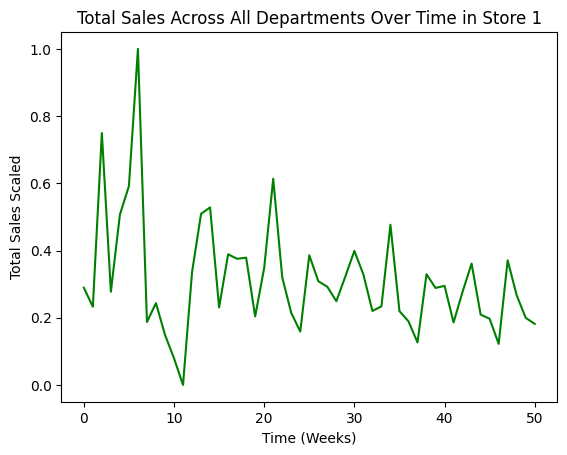

In [7]:
from sklearn.preprocessing import MinMaxScaler

# using RNN to predict prices of store 1

features = ["Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "CPI", "Unemployment"]

X, y = [], []
train_len = int(0.8*51)
for index, row in pdf.iterrows():
    if row["Store"] == 1:
        X.append(row["Date"])
        y.append(sum([row[dept] if not np.isnan(row[dept]) and row[dept] else 0 for dept in departments]))

mm = MinMaxScaler()

X_ss = np.array(X).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

y_mm = mm.fit_transform(y) 

# X_train, X_test, y_train, y_test = X_ss[0:train_len], X_ss[train_len:], y_mm[0:train_len], y_mm[train_len:]

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

fig, ax = plt.subplots()
ax.set_xlabel("Time (Weeks)")
ax.set_ylabel("Total Sales Scaled")
ax.set_title("Total Sales Across All Departments Over Time in Store 1")
plt.plot(X_ss, y_mm, "g-")
# plt.savefig("figures/Sales-Over-Time-Store1-v2.png")

### Importing Libraries

To implement this RNN, I used PyTorch's `nn` module and created a custom class that implements a basic RNN. The `Variable` class is used to convert NumPy arrays into PyTorch tensors, which are required for PyTorch models.

In [9]:
import torch 
import torch.nn as nn
from torch.autograd import Variable

Convert the X and y data from 2D numpy arrays to 2D torch tensors

In [10]:
X_train_tensors = Variable(torch.Tensor(X_ss))

y_train_tensors = Variable(torch.Tensor(y_mm))

Convert the 2D tensors into 3D tensors

In [11]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)


Training Shape torch.Size([51, 1, 1]) torch.Size([51, 1])


### Defining a Custom LSTM Model

Below, I define a custom LSTM model, a type of RNN that is particularly effective for analyzing time series data. LSTMs are widely used in stock price predictions and can be applied to sales forecasting as well.

When initializing the class, I define the following variables:
- `num_classes`: The number of output classes. In our case, this is 1 since the output is the total sales for Store 1.
- `input_size`: The size of the input, which is also 1 since our input is just a timestep.
- `hidden_size`: The size of the hidden layers. I chose a value of 150 to capture complex patterns without significantly slowing down the network. Increasing the hidden size further would slow down the model without providing a substantial increase in accuracy.
- `num_layers`: The number of layers in the LSTM.
- `seq_length`: The number of timesteps used for training. In our case, it is 50 since we are forecasting sales data over 50 weeks.

The `forward` method performs a forward pass through the RNN, passing the input through each layer sequentially. The output from each layer is used as the input for the next one until the final output is produced.

In [28]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out)
        out = self.fc(out) 
        return out

Define parameters for the LSTM model

In [41]:
input_size = 1 
hidden_size = 150
num_layers = 1

Instantiate the LSTM with the specified parameters

In [42]:
lstm1 = LSTM1(1, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

Setting the error measurement to be mean-sqaured error, which is best for regression tasks like sales forcasting. Setting the optimizer to be adam.

In [43]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=0.01) 

### Model Training

The training process goes as follows:
1. Compute the output after one forward pass in the RNN
2. Calculate the gradient
3. Instantiate the loss function and calculate the loss
4. Update the model parameters using Stochastic Gradient Descent (SGD)
5. Repeat for each epoch, printing the loss every 100th epoch

The gradual decrease in loss during the training process indicates that the model is being trained properly.

In [44]:
for epoch in range(1000):
  outputs = lstm1.forward(X_train_tensors_final) 
  optimizer.zero_grad() 
 
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() 
 
  optimizer.step() 
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.12327
Epoch: 100, loss: 0.01516
Epoch: 200, loss: 0.00802
Epoch: 300, loss: 0.00751
Epoch: 400, loss: 0.00720
Epoch: 500, loss: 0.00742
Epoch: 600, loss: 0.01055
Epoch: 700, loss: 0.00696
Epoch: 800, loss: 0.00705
Epoch: 900, loss: 0.00665


### Making Predictions Using the Model

After training the model, I performed 50 forward passes to forecast sales data over the next 50 weeks. While the model successfully predicted the general trend in sales over time, it overfitted to the pattern seen in the first 10 weeks, where sales values were significantly higher. As a result, the model struggled to generalize to the sales patterns in the later weeks.

Below is a graph comparing the forecasted and actual sales data. The green lines represent the actual sales over time, while the red lines represent the predicted sales.

![Forecasted Sales Data](figures/Forecasted-Sales.png)

### Improvements

Some potential improvements include:
1. Using a combination of time and feature data in the RNN to better capture relationships beyond just time.
2. Training the model only on data after the first 10 weeks to avoid the bias caused by the initial sales spike.
3. Providing the model with more training data, assuming the sales pattern remains consistent, could also improve its accuracy.

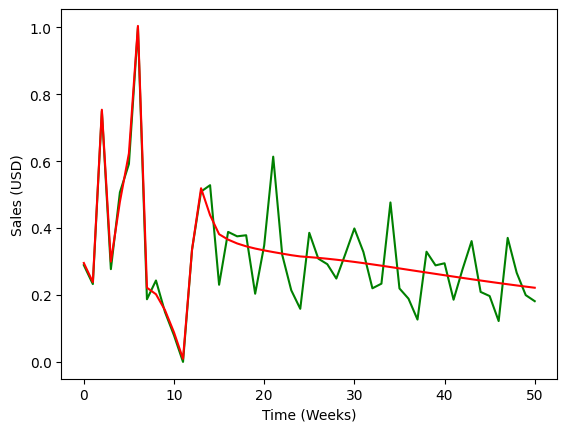

In [45]:
predictions = lstm1(X_train_tensors_final)

pred_arr = predictions.detach().numpy()

fig, ax = plt.subplots()
ax.set_xlabel("Time (Weeks)")
ax.set_ylabel("Sales (USD)")
plt.plot(X_ss, y_mm, "g-")
plt.plot(X_ss, pred_arr, "r-")
plt.savefig("figures/Forecasted-Sales.png")
plt.show()
